***This is a reduced copy of the complete project ipynb in its form at the time, to be imported by the other files in this repo for model testing.***

First, we will import the data and necessary packages:

In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
df = pd.read_csv('bank_data.csv')
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [3]:
df['y'].replace(['no', 'yes'],[0, 1], inplace=True) # convert categorical target to numeric

In [4]:
df2 = df[(df["balance"] < 80000) & (df["duration"] < 3500) & (df["campaign"] < 50) & (df["previous"] < 50)] #saving as separate dataframe to use the original for further analysis
df3 = df[(df["balance"] < 80000) & (df["duration"] < 3500) & (df["campaign"] < 50) & (df["previous"] < 50)]


In [5]:
def education_filler(row):
    if row['job'] == 'management':
        return 'tertiary'
    elif row['job'] == 'housemaid':
        return 'primary'
    else:
        return 'secondary' # mode replacement. secondary education is the most common value.

df2['education'][df2['education'].isnull() == True] = df2.apply(education_filler, axis = 1)

Similarly, we might be able to derive some conclusions about our missing values on 'job' from the age of our subjects. People below 22 years old tend to be students, while people over 60 tend to be retired by a large margin.

In [6]:
def job_filler(row):
    if row['age'] <= 22:
        return 'student'
    elif row['age'] >= 60:
        return 'retired'
    else:
        return 'blue-collar' # mode replacement.

df2['job'][df2['job'].isnull() == True] = df2.apply(job_filler, axis = 1)

In [7]:
df2 = df2.drop(['contact', 'poutcome'], axis = 1)

In [8]:
df3 = df3.drop(['contact', 'poutcome'], axis = 1).dropna()

In [9]:
df2 = pd.get_dummies(df2, columns = ['job','marital','education','default','housing','loan','month'], drop_first=True)
df3 = pd.get_dummies(df3, columns = ['job','marital','education','default','housing','loan','month'], drop_first=True)

In [10]:
import category_encoders as ce

X_cols = df.drop('y', axis = 1).columns
# Create a WOE encoder
encoder = ce.WOEEncoder(cols = X_cols)

# Fit the encoder on the data
encoder.fit(df[X_cols], df['y'])

# Transform the data using the encoder
df_woe = encoder.transform(df[X_cols])

In [77]:
from sklearn import preprocessing       #normalize data
scaler = preprocessing.MinMaxScaler()
ndf_woe = scaler.fit_transform(df_woe)
ndf_woe = pd.DataFrame(ndf_woe, columns = df_woe.columns)

<Axes: >

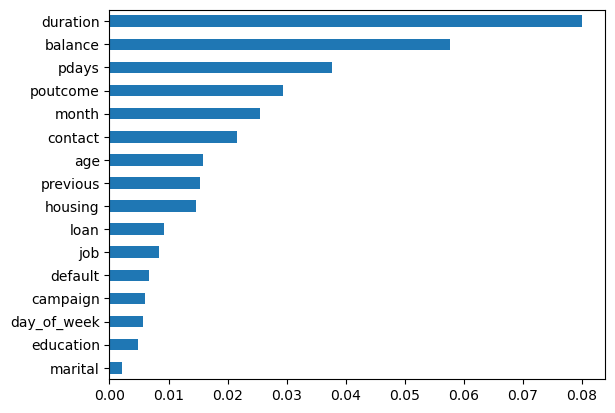

In [79]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot

importances = mutual_info_classif(ndf_woe, df['y'])
feat_importances = pd.Series(importances, df.columns[0:len(df.columns)-1])
feat_importances.sort_values().plot(kind = 'barh')

In [86]:
ndf_woe.drop(['education', 'day_of_week', 'marital', 'default', 'job', 'loan'], axis = 1, inplace=True)

In [81]:
# Synthetic minority oversampling technique
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority')
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(ndf_woe, df['y'])
oversampled_df = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)